In [223]:
#Import Libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier


from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV

In [225]:
# Load the train and test datasets
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [227]:
# Display the first few rows of the training dataset
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [229]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [231]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [233]:
# Show statistical description of categorical columns
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [235]:
# Calculate the survival rate by passenger class
train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [237]:
# Calculate the survival rate by gender
train_df.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [239]:
# Calculate the survival rate by number of siblings/spouses aboard
train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [241]:
# Calculate the survival rate by number of parents/children aboard
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [243]:
# Create a new feature 'Family_Size' and calculate survival rate by family size
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [245]:
train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [247]:
# Group 'Family_Size' into categories and calculate the survival rate by family size group
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
train_df['Family_Size_Grouped'] = train_df['Family_Size'].map(family_map)
test_df['Family_Size_Grouped'] = train_df['Family_Size'].map(family_map)

In [249]:
train_df.groupby(['Family_Size_Grouped'], as_index=False)['Survived'].mean()

,Family_Size_Grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


In [251]:
train_df.groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


C:\Users\b_sen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


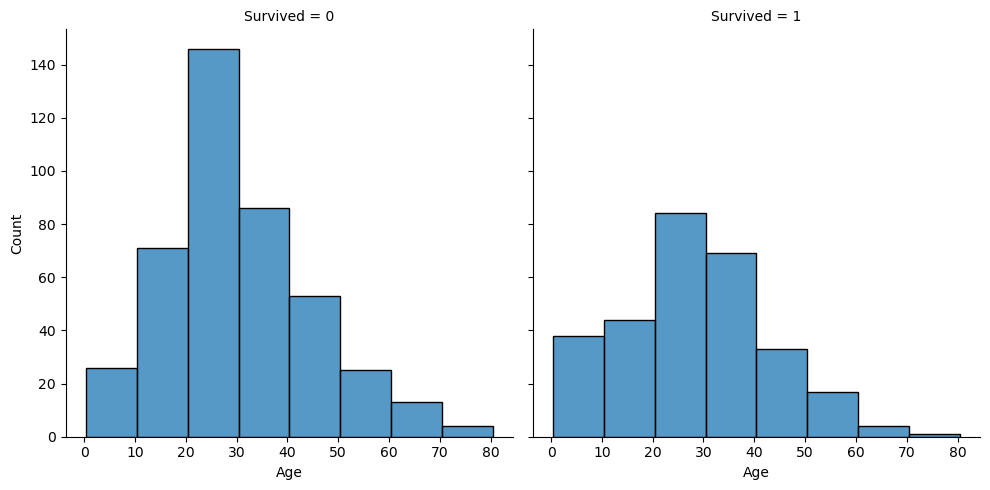

In [253]:
# Plot the distribution of age by survival status
sns.displot(train_df, x='Age', col='Survived', binwidth=10, height=5)

In [255]:
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 5)
test_df['Age_Cut'] = pd.qcut(test_df['Age'], 5)

In [257]:
# Calculate survival rate by age categories
train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()

C:\Users\b_sen\AppData\Local\Temp\ipykernel_13132\3823991707.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()


,Age_Cut,Survived
0,"(0.419, 19.0]",0.481707
1,"(19.0, 25.0]",0.328467
2,"(25.0, 31.8]",0.393701
3,"(31.8, 41.0]",0.437500
4,"(41.0, 80.0]",0.373239


In [259]:
# Replace age with age categories for simplicity
train_df.loc[train_df['Age'] <= 19, 'Age'] = 0
train_df.loc[(train_df['Age'] > 19) & (train_df['Age'] <= 25), 'Age'] = 1
train_df.loc[(train_df['Age'] > 25) & (train_df['Age'] <= 31.8), 'Age'] = 2
train_df.loc[(train_df['Age'] > 31.8) & (train_df['Age'] <= 41), 'Age'] = 3
train_df.loc[(train_df['Age'] > 41) & (train_df['Age'] <= 80), 'Age'] = 4
train_df.loc[train_df['Age'] > 80, 'Age'] 

Series([], Name: Age, dtype: float64)

In [261]:
# Apply the same transformation to the test dataset
test_df.loc[test_df['Age'] <= 19, 'Age'] = 0
test_df.loc[(test_df['Age'] > 19) & (test_df['Age'] <= 25), 'Age'] = 1
test_df.loc[(test_df['Age'] > 25) & (test_df['Age'] <= 31.8), 'Age'] = 2
test_df.loc[(test_df['Age'] > 31.8) & (test_df['Age'] <= 41), 'Age'] = 3
test_df.loc[(test_df['Age'] > 41) & (test_df['Age'] <= 80), 'Age'] = 4
test_df.loc[test_df['Age'] > 80, 'Age'] 

Series([], Name: Age, dtype: float64)

In [263]:
#Display after transformations
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(19.0, 25.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,71.2833,C85,C,2,Small,"(31.8, 41.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(25.0, 31.8]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,53.1000,C123,S,2,Small,"(31.8, 41.0]"
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,8.0500,NaN,S,1,Alone,"(31.8, 41.0]"


C:\Users\b_sen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


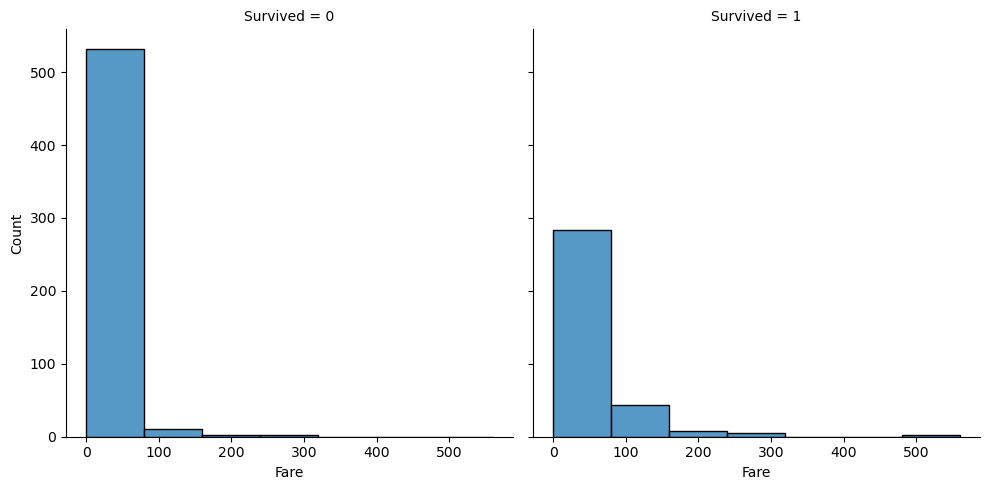

In [265]:
# Plot the distribution of fare by survival status
sns.displot(train_df, x='Fare', col='Survived', binwidth=80, height=5)

In [267]:
# Group fare into categories using quantiles
train_df['Fare_Cut'] = pd.qcut(train_df['Fare'], 5)
test_df['Fare_Cut'] = pd.qcut(test_df['Fare'], 5)

In [269]:
# Calculate survival rate by fare categories
train_df.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()

C:\Users\b_sen\AppData\Local\Temp\ipykernel_13132\3480845082.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()


,Fare_Cut,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


In [271]:
# Replace fare with fare categories for simplicity
train_df.loc[train_df['Fare'] <= 7.854, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.854) & (train_df['Fare'] <= 10.5), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 10.5) & (train_df['Fare'] <= 21.679), 'Fare'] = 2
train_df.loc[(train_df['Fare'] > 21.679) & (train_df['Fare'] <= 39.688), 'Fare'] = 3
train_df.loc[(train_df['Fare'] > 39.688) & (train_df['Fare'] <= 512.329), 'Fare'] = 4
train_df.loc[train_df['Fare'] > 512.329, 'Fare'] 

258    512.3292
679    512.3292
737    512.3292
Name: Fare, dtype: float64

In [273]:
# Apply the same transformation to the test dataset
test_df.loc[test_df['Fare'] <= 7.854, 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 7.854) & (test_df['Fare'] <= 10.5), 'Fare'] = 1
test_df.loc[(test_df['Fare'] > 10.5) & (test_df['Fare'] <= 21.679), 'Fare'] = 2
test_df.loc[(test_df['Fare'] > 21.679) & (test_df['Fare'] <= 39.688), 'Fare'] = 3
test_df.loc[(test_df['Fare'] > 39.688) & (test_df['Fare'] <= 512.329), 'Fare'] = 4
test_df.loc[test_df['Fare'] > 512.329, 'Fare'] 

343    512.3292
Name: Fare, dtype: float64

In [275]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

<br>

Extract titles from the names

In [279]:
train_df['Title'] = train_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())

In [281]:
test_df['Title'] = test_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())

In [283]:
# Calculate survival rate by title
train_df.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


In [285]:
# Replace less common titles with broader categories
train_df['Title'] = train_df['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'    
})

In [287]:
test_df['Title'] = test_df['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'    
})

In [289]:
# Calculate count and mean survival rate by title
train_df.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,9,0.777778
7,Rev,6,0.000000


In [291]:
# Calculate name length and its relationship with survival
train_df['Name_Length'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Length'] = test_df['Name'].apply(lambda x: len(x))

C:\Users\b_sen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\b_sen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


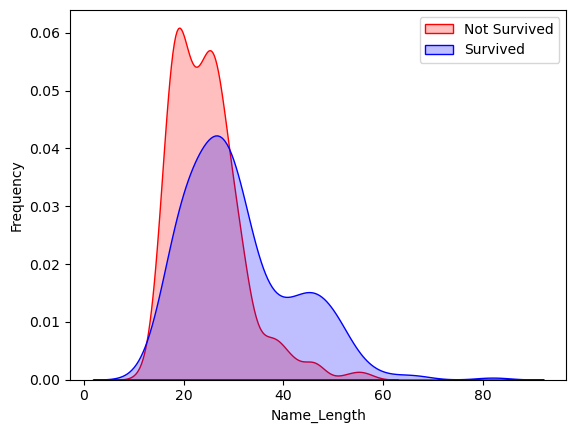

In [293]:
# Plot name length distribution by survival status
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==0) & (train_df['Name_Length'].notnull())], color='Red', fill=True)
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==1) & (train_df['Name_Length'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Name_Length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [295]:
# Group name length into categories and calculate survival rate
train_df['Name_LengthGB'] = pd.qcut(train_df['Name_Length'], 3)
test_df['Name_LengthGB'] = pd.qcut(test_df['Name_Length'], 3)

In [297]:
# Calculate survival rate by name length groups
train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()

C:\Users\b_sen\AppData\Local\Temp\ipykernel_13132\556805541.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()


,Name_LengthGB,Survived
0,"(11.999, 22.0]",0.252336
1,"(22.0, 28.0]",0.322581
2,"(28.0, 82.0]",0.587629


In [299]:
# Replace name length with categories for simplicity
train_df.loc[train_df['Name_Length'] <= 22, 'Name_Size'] = 0
train_df.loc[(train_df['Name_Length'] > 22) & (train_df['Name_Length'] <= 28), 'Name_Size'] = 1
train_df.loc[(train_df['Name_Length'] > 28) & (train_df['Name_Length'] <= 82), 'Name_Size'] = 2
train_df.loc[train_df['Name_Length'] > 82, 'Name_Size'] 

Series([], Name: Name_Size, dtype: float64)

In [301]:
# Apply the same transformation to the test dataset
test_df.loc[test_df['Name_Length'] <= 22, 'Name_Size'] = 0
test_df.loc[(test_df['Name_Length'] > 22) & (test_df['Name_Length'] <= 28), 'Name_Size'] = 1
test_df.loc[(test_df['Name_Length'] > 28) & (test_df['Name_Length'] <= 82), 'Name_Size'] = 2
test_df.loc[test_df['Name_Length'] > 82, 'Name_Size'] 

Series([], Name: Name_Size, dtype: float64)

In [303]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,NaN,S,2,Small,"(19.0, 25.0]","(-0.001, 7.854]",Mr,23,"(22.0, 28.0]",1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,4.0,C85,C,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,51,"(28.0, 82.0]",2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,1.0,NaN,S,1,Alone,"(25.0, 31.8]","(7.854, 10.5]",Miss,22,"(11.999, 22.0]",0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,4.0,C123,S,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,44,"(28.0, 82.0]",2.0
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,1.0,NaN,S,1,Alone,"(31.8, 41.0]","(7.854, 10.5]",Mr,24,"(22.0, 28.0]",1.0


In [305]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [307]:
# Extract ticket number and process it
train_df['TicketNumber'] = train_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test_df['TicketNumber'] = test_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [309]:
# Calculate survival rate by ticket number
train_df.groupby(['TicketNumber'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumber,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
...,...,...,...
271,2662,1,0.000000
272,2663,1,1.000000
273,2664,1,0.000000
276,2667,1,1.000000


In [311]:
train_df.groupby('TicketNumber')['TicketNumber'].transform('count')

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: TicketNumber, Length: 891, dtype: int64

In [313]:
# Count how many people shared the same ticket number
train_df['TicketNumberCounts'] = train_df.groupby('TicketNumber')['TicketNumber'].transform('count')
test_df['TicketNumberCounts'] = test_df.groupby('TicketNumber')['TicketNumber'].transform('count')

In [315]:
# Calculate survival rate by ticket number counts
train_df.groupby(['TicketNumberCounts'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumberCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [317]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [319]:
train_df['Ticket'].str.split(pat=" ", expand=True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [321]:
train_df['TicketLocation'] = np.where(train_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), train_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

In [323]:
test_df['TicketLocation'] = np.where(test_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), test_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

In [325]:
train_df['TicketLocation'].value_counts()

TicketLocation
Blank         665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64

In [327]:
# Standardize the ticket location values
train_df['TicketLocation'] = train_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [329]:
test_df['TicketLocation'] = test_df['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C',    
})

In [331]:
# Calculate survival rate by ticket location
train_df.groupby(['TicketLocation'], as_index=False)['Survived'].agg(['count', 'mean'])

,TicketLocation,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


In [333]:
# Fill missing cabin data and extract the first letter of each cabin
train_df['Cabin'] = train_df['Cabin'].fillna('U')
train_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in train_df['Cabin']])

In [335]:
test_df['Cabin'] = test_df['Cabin'].fillna('U')
test_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in test_df['Cabin']])

In [337]:
# Calculate survival rate by cabin type
train_df.groupby(['Cabin'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


In [339]:
# Fill missing cabin data and extract the first letter of each cabin
train_df['Cabin_Assigned'] = train_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test_df['Cabin_Assigned'] = test_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [341]:
# Calculate survival rate by cabin type
train_df.groupby(['Cabin_Assigned'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [343]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size,TicketNumber,TicketNumberCounts,TicketLocation,Cabin_Assigned
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,...,"(19.0, 25.0]","(-0.001, 7.854]",Mr,23,"(22.0, 28.0]",1.0,21171,1,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,4.0,...,"(31.8, 41.0]","(39.688, 512.329]",Mrs,51,"(28.0, 82.0]",2.0,17599,1,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,1.0,...,"(25.0, 31.8]","(7.854, 10.5]",Miss,22,"(11.999, 22.0]",0.0,3101282,1,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,4.0,...,"(31.8, 41.0]","(39.688, 512.329]",Mrs,44,"(28.0, 82.0]",2.0,113803,2,Blank,1
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,1.0,...,"(31.8, 41.0]","(7.854, 10.5]",Mr,24,"(22.0, 28.0]",1.0,373450,1,Blank,0


In [345]:
# Check the shape of the training and test datasets
train_df.shape

(891, 24)

In [347]:
test_df.shape

(418, 23)

In [349]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  714 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  Family_Size          891 non-null    int64   
 13  Family_Size_Grouped  891 non-null    object  
 14  Age_Cut              714 non-null    category
 15  Fare_Cut             89

In [351]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size',
       'Family_Size_Grouped', 'Age_Cut', 'Fare_Cut', 'Title', 'Name_Length',
       'Name_LengthGB', 'Name_Size', 'TicketNumber', 'TicketNumberCounts',
       'TicketLocation', 'Cabin_Assigned'],
      dtype='object')

In [353]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    float64 
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_Size          418 non-null    int64   
 12  Family_Size_Grouped  418 non-null    object  
 13  Age_Cut              332 non-null    category
 14  Fare_Cut             417 non-null    category
 15  Title                41

In [355]:
# Fill missing values in age and fare columns with the mean
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

In [357]:
# Initialize encoders and imputers
ohe = OneHotEncoder(sparse_output=False)
ode = OrdinalEncoder
SI = SimpleImputer(strategy='most_frequent')

In [359]:
# Define columns for ordinal and one-hot encoding
ode_cols = ['Family_Size_Grouped']
ohe_cols = ['Sex', 'Embarked']

<Axes: >

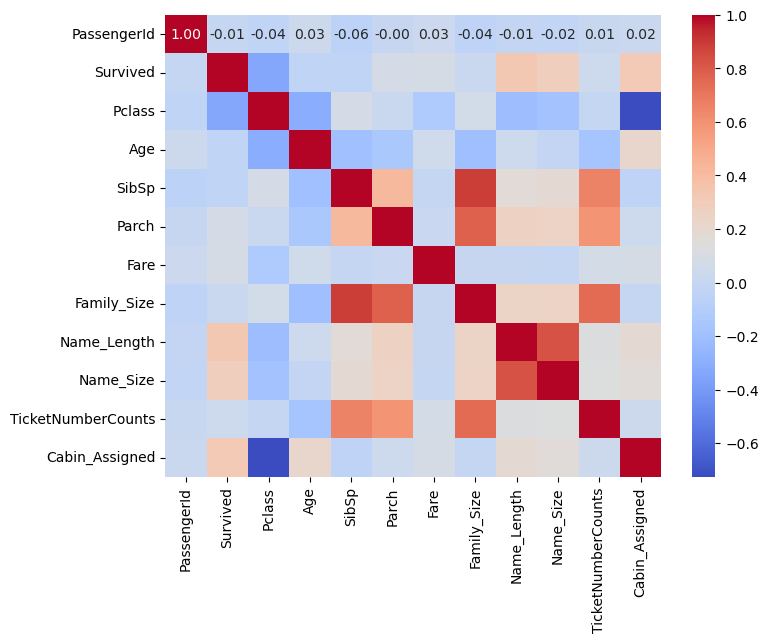

In [361]:
# Correleation Matrix
correlation_matrix = train_df.corr(numeric_only=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [379]:
# Drop 'Survived', 'SibSp', and 'Parch' columns from the training set to create feature matrix X
X = train_df.drop(['Survived', 'SibSp', 'Parch'], axis=1)

# Set the target variable y as the 'Survived' column
y = train_df['Survived']

# Drop unnecessary columns from the test set to create feature matrix X_test
X_test = test_df.drop(['Age_Cut', 'Fare_Cut', 'SibSp', 'Parch'], axis=1)

In [381]:
# Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y, random_state=21)

In [383]:
# Create a pipeline for ordinal encoding with imputation of missing values using the most frequent strategy
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), # Impute missing values with the most frequent values
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # Ordinal encode the categorical variables
])

In [385]:
# Create a pipeline for one-hot encoding with imputation of missing values using the most frequent strategy
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), # Impute missing values with the most frequent values
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False)) # One-hot encode the categorical variables
])

In [387]:
# Combine the preprocessing pipelines into a ColumnTransformer
col_trans = ColumnTransformer(transformers=[
    ('impute', SI, ['Age']), # Impute missing values in 'Age'
    ('ord_pipeline', ordinal_pipeline, ode_cols), # Apply the ordinal pipeline to the specified columns
    ('ohe_pipeline', ohe_pipeline, ohe_cols), # Apply the one-hot encoding pipeline to the specified columns
     ('passthrough', 'passthrough', ['Pclass', 'Cabin_Assigned', 'Name_Size', 'Age', 'Fare', 'TicketNumberCounts']) # Keep certain columns unchanged (passthrough
    ],
    remainder='drop', # Drop any remaining columns that are not transformed
    n_jobs=-1) #  Use parallel processing to speed up the transformations

In [389]:
# Initialize a RandomForestClassifier
rfc = RandomForestClassifier()

In [399]:
# Define a parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [150, 200, 300, 500], # Number of trees in the forest
    'min_samples_split': [5, 10, 15], # Minimum number of samples required to split an internal node
    'max_depth': [10, 13, 15, 17, 20],  # Maximum depth of the tree
    'min_samples_leaf': [2, 4, 5, 6], # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy'], # Function to measure the quality of a split
}

In [401]:
# Initialize GridSearchCV for hyperparameter tuning with 5-fold cross-validation
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

Create a final pipeline combining the column transformer and the grid search for the random forest model<br>
Fit the final pipeline to the training data

In [78]:
pipefinalrfc = make_pipeline(col_trans, CV_rfc)
pipefinalrfc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 13, 15, 17, 20],
                                          'min_samples_leaf': [2, 4, 5, 6],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [150, 200, 300,
                                                           500]}))])

In [157]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 200}
0.8272431793558555


In [159]:
dtc = DecisionTreeClassifier()

In [161]:
param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

In [163]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [165]:
pipefinaldtc = make_pipeline(col_trans, CV_dtc)
pipefinaldtc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 20, 30],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]}))])

In [167]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 15}
0.8061459667093469


In [169]:
knn = KNeighborsClassifier()

In [171]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2],
}

In [173]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [175]:
pipefinalknn = make_pipeline(col_trans, CV_knn)
pipefinalknn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [177]:
print(CV_knn.best_params_)
print(CV_knn.best_score_)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8047670639219934


In [179]:
svc = SVC(probability=True)

In [181]:
param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
}

In [183]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [185]:
pipefinalsvc = make_pipeline(col_trans, CV_svc)
pipefinalsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(probability=True),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']}))])

In [187]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 10, 'kernel': 'rbf'}
0.8005614104205654


In [189]:
lr = LogisticRegression()

In [191]:
param_grid = {
    'C': [100,10, 1.0, 0.1, 0.001, 0.001],
}

In [193]:
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [195]:
pipefinallr= make_pipeline(col_trans, CV_lr)
pipefinallr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001,
                                                0.001]}))])

In [197]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'C': 0.1}
0.8047867625332413


In [199]:
gnb = GaussianNB()

In [201]:
param_grid = {
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001],
}

In [203]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [205]:
pipefinalgnb= make_pipeline(col_trans, CV_gnb)
pipefinalgnb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-08, 1e-09,
                                                            1e-08]}))])

In [207]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-08}
0.7654781837880429


In [209]:
xg = XGBClassifier()

In [211]:
param_grid = {
     'booster': ['gbtree', 'gblinear','dart'],
}

In [213]:
CV_xg = GridSearchCV(estimator=xg, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [215]:
pipefinalxg= make_pipeline(col_trans, CV_xg)
pipefinalxg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'booster': ['gbtree', 'gblinear',
                                                      'dart']}))])

In [217]:
print(CV_xg.best_params_)
print(CV_xg.best_score_)

{'booster': 'gblinear'}
0.8019600118191667


In [219]:
abc = AdaBoostClassifier()

In [221]:
dtc_2 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10,min_samples_leaf=4, min_samples_split=10)  
svc_2 = SVC(probability=True, C=10, kernel='rbf') 
lr_2 = LogisticRegression(C=0.1) 
lr_3 = LogisticRegression(C=0.2) 
lr_4 = LogisticRegression(C=0.05) 

In [223]:
param_grid = {
    'estimator': [dtc_2, svc_2, lr_2], 
    'n_estimators':  [5, 10, 25, 50, 100],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [(0.97 + x / 100) for x in range(1, 7)]  
}

In [225]:
CV_abc = GridSearchCV(estimator=abc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [227]:
pipefinalabc= make_pipeline(col_trans, CV_abc)
pipefinalabc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=AdaBoostClassifier(),
                              param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                                          'estimator': [DecisionTreeClassifier(criterion='entropy',
                                                                               max_depth=10,
                                                                               min_samples_leaf=4,
                                                                               min_samples_split=10),
                                                        SVC(C=10,
                                                            probability=True),
                                                        LogisticRegression(C=0.1)],
                                          'learning_rate': [0.98, 0.99, 1.0,
                                                            1.01, 1.02, 1.03],
                                          'n_estimators': [5, 10, 25, 50,
                                                           100]}))])

In [229]:
print(CV_abc.best_params_)
print(CV_abc.best_score_)

{'algorithm': 'SAMME', 'estimator': LogisticRegression(C=0.1), 'learning_rate': 1.0, 'n_estimators': 25}
0.7963951541416331


In [231]:
etc = ExtraTreesClassifier()

In [233]:
param_grid = {
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[100,300],
}

In [235]:
CV_etc = GridSearchCV(estimator=etc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [237]:
pipefinaletc= make_pipeline(col_trans, CV_etc)
pipefinaletc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                 ('passthrough', 'passthrough',
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=ExtraTreesClassifier(),
                              param_grid={'max_features': [1, 3, 10],
                                          'min_samples_leaf': [1, 3, 10],
                                          'min_samples_split': [2, 3, 10],
                                          'n_estimators': [100, 300]}))])

In [239]:
print(CV_etc.best_params_)
print(CV_etc.best_score_)

{'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
0.814596670934699


In [241]:
GBC = GradientBoostingClassifier()

In [243]:
param_grid = {
              'n_estimators' : [300, 400, 500],
              'learning_rate': [ 0.1, 0.3, 0.6, 1.0],
              'max_depth': [8, 10, 12],
              'min_samples_leaf': [50, 100, 120, 150],
              'max_features': [0.1, 0.3, 0.5] 
              }

In [245]:
CV_gbc = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [247]:
pipefinalgbc= make_pipeline(col_trans, CV_gbc)
pipefinalgbc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GradientBoostingClassifier(),
                              param_grid={'learning_rate': [0.1, 0.3, 0.6, 1.0],
                                          'max_depth': [8, 10, 12],
                                          'max_features': [0.1, 0.3, 0.5],
                                          'min_samples_leaf': [50, 100, 120,
                                                               150],
                                          'n_estimators': [300, 400, 500]}))])

In [249]:
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)

{'learning_rate': 0.3, 'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 400}
0.8315276273022751


In [251]:
vc1 = VotingClassifier([('gbc', CV_gbc.best_estimator_),
                        ('etc', CV_etc.best_estimator_),
                          ('nb', CV_gnb.best_estimator_)
                         ], voting='hard', weights=[1,2,3] )

In [253]:
vc2 = VotingClassifier([('abc', CV_abc.best_estimator_),
                        ('etc', CV_etc.best_estimator_),
                          ('nb', CV_gnb.best_estimator_)
                         ], voting='hard', weights=[1,2,3] )

In [255]:
pipefinalcv1 = make_pipeline(col_trans, vc1)

In [257]:
pipefinalcv2 = make_pipeline(col_trans, vc2)

In [259]:
pipefinalcv1.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('gbc',
                                               GradientBoostingClassifier(learning_rate=0.3,
                                                                          max_depth=10,
                                                                          max_features=0.3,
                                                                          min_samples_leaf=100,
                                                                          n_estimators=400)),
                                              ('etc',
                                               ExtraTreesClassifier(max_features=1,
                                                                    min_samples_split=10,
                                                                    n_estimators=300)),
                                              ('nb',
                                               GaussianNB(var_smoothing=1e-08))],
                                  weights=[1, 2, 3]))])

In [261]:
pipefinalcv2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped']),
                                                 ('ohe_pipeline',
                                                  Pipeline(s...
                                                  ['Pclass', 'Cabin_Assigned',
                                                   'Name_Size', 'Age', 'Fare',
                                                   'TicketNumberCounts'])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('abc',
                                               AdaBoostClassifier(algorithm='SAMME',
                                                                  estimator=LogisticRegression(C=0.1),
                                                                  n_estimators=25)),
                                              ('etc',
                                               ExtraTreesClassifier(max_features=1,
                                                                    min_samples_split=10,
                                                                    n_estimators=300)),
                                              ('nb',
                                               GaussianNB(var_smoothing=1e-08))],
                                  weights=[1, 2, 3]))])

In [263]:
Y_pred = pipefinalrfc.predict(X_test)
Y_pred2 = pipefinaldtc.predict(X_test)
Y_pred3 = pipefinalknn.predict(X_test)
Y_pred4 = pipefinalsvc.predict(X_test)
Y_pred5 = pipefinallr.predict(X_test)
Y_pred6 = pipefinalgnb.predict(X_test)
Y_pred7 = pipefinalxg.predict(X_test)
Y_pred8 = pipefinalabc.predict(X_test)
Y_pred9 = pipefinaletc.predict(X_test)
Y_pred10 = pipefinalgbc.predict(X_test)
Y_pred11 = pipefinalcv1.predict(X_test)
Y_pred12 = pipefinalcv2.predict(X_test)

In [265]:
output = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred
})

output2 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred2
})

output3 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred3
})

output4 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred4
})

output5 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred5
})

output6 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred6
})

output7 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred7
})

output8 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred8
})

output9 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred9
})

output10 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred10
})

output11 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred11
})

output12 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred12
})

In [267]:
output.to_csv('./outputf/output_1.csv', index=False)
output2.to_csv('./outputf/output_2.csv', index=False)
output3.to_csv('./outputf/output_3.csv', index=False)
output4.to_csv('./outputf/output_4.csv', index=False)
output5.to_csv('./outputf/output_5.csv', index=False)
output6.to_csv('./outputf/output_6.csv', index=False)
output7.to_csv('./outputf/output_7.csv', index=False)
output8.to_csv('./outputf/output_8.csv', index=False)
output9.to_csv('./outputf/output_9.csv', index=False)
output10.to_csv('./outputf/output_10.csv', index=False)
output11.to_csv('./outputf/output_11.csv', index=False)
output12.to_csv('./outputf/output_12.csv', index=False)